<a href="https://colab.research.google.com/github/sumitsisodiya/ChatterBot/blob/master/image_caption_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import string
import numpy as np
from PIL import Image
import os
from pickle import dump, load
import numpy as np
import pydot_ng as pydot
import tensorflow as tf

from keras.applications.vgg16 import VGG16
from keras.models import Sequential
from keras.applications.xception import Xception, preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers.merge import add
from keras.models import Model, load_model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout,BatchNormalization
from os import listdir

In [4]:
# small library for seeing the progress of loops.
from tqdm.notebook import tqdm
tqdm().pandas()

# Loading a text file into memory
def load_doc(filename):
    # Opening the file as read only
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

# get all imgs with their captions
def all_img_captions(filename):
    file = load_doc(filename)
    captions = file.split('\n')
    descriptions ={}
    for caption in captions[:-1]:
        img, caption = caption.split('\t')
        if img[:-2] not in descriptions:
            descriptions[img[:-2]] = [ caption ]
        else:
            descriptions[img[:-2]].append(caption)
    return descriptions

#Data cleaning- lower casing, removing puntuations and words containing numbers
def cleaning_text(captions):
    table = str.maketrans('','',string.punctuation)
    for img,caps in captions.items():
        for i,img_caption in enumerate(caps):

            img_caption.replace("-"," ")
            desc = img_caption.split()

            #converts to lowercase
            desc = [word.lower() for word in desc]
            #remove punctuation from each token
            desc = [word.translate(table) for word in desc]
            #remove hanging 's and a 
            desc = [word for word in desc if(len(word)>1)]
            #remove tokens with numbers in them
            desc = [word for word in desc if(word.isalpha())]
            #convert back to string

            img_caption = ' '.join(desc)
            captions[img][i]= img_caption
    return captions

def text_vocabulary(descriptions):
    # build vocabulary of all unique words
    vocab = set()

    for key in descriptions.keys():
        [vocab.update(d.split()) for d in descriptions[key]]

    return vocab

#All descriptions in one file 
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + '\t' + desc )
    data = "\n".join(lines)
    file = open(filename,"w")
    file.write(data)
    file.close()


# Set these path according to project folder in you system
dataset_text = "/content/drive/MyDrive/Flickerdata"
dataset_images = "/content/drive/MyDrive/Flickerdata/Flicker8k_Dataset"

#we prepare our text data
filename = dataset_text + "/" + "Flickr8k.token.txt"
#loading the file that contains all data
#mapping them into descriptions dictionary img to 5 captions
descriptions = all_img_captions(filename)
print(descriptions)
print("Length of descriptions =" ,len(descriptions))

#cleaning the descriptions
clean_descriptions = cleaning_text(descriptions)

#building vocabulary 
vocabulary = text_vocabulary(clean_descriptions)
print(vocabulary)
print("Length of vocabulary = ", len(vocabulary))

#saving each description to file 
save_descriptions(clean_descriptions, "descriptions.txt")


/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel



{'1000268201_693b08cb0e.jpg': ['A child in a pink dress is climbing up a set of stairs in an entry way .', 'A girl going into a wooden building .', 'A little girl climbing into a wooden playhouse .', 'A little girl climbing the stairs to her playhouse .', 'A little girl in a pink dress going into a wooden cabin .'], '1001773457_577c3a7d70.jpg': ['A black dog and a spotted dog are fighting', 'A black dog and a tri-colored dog playing with each other on the road .', 'A black dog and a white dog with brown spots are staring at each other in the street .', 'Two dogs of different breeds looking at each other on the road .', 'Two dogs on pavement moving toward each other .'], '1002674143_1b742ab4b8.jpg': ['A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .', 'A little girl is sitting in front of a large painted rainbow .', 'A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .', 'There is a girl with pig

In [5]:
def extract_features(directory):
	# load the model
	model = VGG16()
	# re-structure the model
	model.layers.pop()
	model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
	# summarize
	print(model.summary())
	# extract features from each photo
	features = dict()
	for name in listdir(directory):
		# load an image from file
		filename = directory + '/' + name
		image = load_img(filename, target_size=(224, 224))
		# convert the image pixels to a numpy array
		image = img_to_array(image)
		# reshape data for the model
		image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
		# prepare the image for the VGG model
		image = preprocess_input(image)
		# get features
		feature = model.predict(image, verbose=0)
		# get image id
		image_id = name
		# store feature
		features[image_id] = feature
		print('>%s' % name)
	return features

#2048 feature vector
features = extract_features(dataset_images)
print(features)
dump(features, open("features.p","wb"))



Streaming output truncated to the last 5000 lines.
>3143980056_7a64a94b58.jpg
>3143765063_a7761b16d3.jpg
>3147758035_e8a70818cb.jpg
>3146630574_05d9ebbed1.jpg
>3143953179_1c08c023a5.jpg
>314685044_da4390728e.jpg
>3144705706_391d7b77c7.jpg
>3149804151_1cc8d10783.jpg
>3148286846_40ae914172.jpg
>315021440_122d56ebd7.jpg
>3150315970_8f045c41a4.jpg
>314940358_ec1958dc1d.jpg
>3150252702_828a570d46.jpg
>314904143_5a216a192b.jpg
>3149038044_c7c94688c6.jpg
>3149919755_f9272b10b3.jpg
>3148647065_2d6cd88cf6.jpg
>3148571800_c5515e6c3d.jpg
>3148811252_2fa9490a04.jpg
>3154152744_4e93ec8a62.jpg
>3150659152_2ace03690b.jpg
>3152317129_177b4678b7.jpg
>315436114_6d386b8c36.jpg
>3150440350_b0f2a9e774.jpg
>3154886184_ac842655b6.jpg
>3154293126_e52bd07524.jpg
>3154641421_d1b9b8c24c.jpg
>3153828367_5fc2c37c07.jpg
>3154528397_89112faf4b.jpg
>3154693053_cfcd05c226.jpg
>3153067758_53f003b1df.jpg
>3150742439_b8a352e1e0.jpg
>3150380412_7021e5444a.jpg
>3154709407_9b0778cbeb.jpg
>3151492269_28d8edaa68.jpg
>31513651

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [5]:
features = load(open("/content/drive/MyDrive/Flickerdata/features .p","rb"))

In [7]:
#load the data 
def load_photos(filename):
    file = load_doc(filename)
    photos = file.split("\n")[:-1]
    return photos


def load_clean_descriptions(filename, photos): 
    #loading clean_descriptions
    file = load_doc(filename)
    descriptions = {}
    for line in file.split("\n"):

        words = line.split()
        if len(words)<1 :
            continue

        image, image_caption = words[0], words[1:]

        if image in photos:
            if image not in descriptions:
                descriptions[image] = []
            desc = '<start> ' + " ".join(image_caption) + ' <end>'
            descriptions[image].append(desc)

    return descriptions


def load_features(photos):
    #loading all features
    all_features = load(open("/content/drive/MyDrive/Flickerdata/features .p","rb"))
    #selecting only needed features
    features = {k:all_features[k] for k in photos}
    return features


filename = dataset_text + "/" + "Flickr_8k.trainImages.txt"

#train = loading_data(filename)
train_imgs = load_photos(filename)
train_descriptions = load_clean_descriptions("descriptions.txt", train_imgs)
train_features = load_features(train_imgs)

In [8]:
#converting dictionary to clean list of descriptions
def dict_to_list(descriptions):
    all_desc = []
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

#creating tokenizer class 
#this will vectorise text corpus
#each integer will represent token in dictionary

# from keras.preprocessing.text import Tokenizer

def create_tokenizer(descriptions):
    desc_list = dict_to_list(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(desc_list)
    return tokenizer

# give each word an index, and store that into tokenizer.p pickle file
tokenizer = create_tokenizer(train_descriptions)
dump(tokenizer, open('tokenizer.p', 'wb'))
vocab_size = len(tokenizer.word_index) + 1
vocab_size

7577

In [9]:
#calculate maximum length of descriptions
def max_length(descriptions):
    desc_list = dict_to_list(descriptions)
    return max(len(d.split()) for d in desc_list)
    
max_length = max_length(descriptions)
max_length

32

In [10]:
#create input-output sequence pairs from the image description.
def create_sequences(tokenizer, max_length, desc_list, feature):
    X1, X2, y = list(), list(), list()
    # walk through each description for the image
    for desc in desc_list:
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        print(len(seq))
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            # store
            X1.append(feature)
            X2.append(in_seq)
            y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)

#data generator, used by model.fit_generator()
def data_generator(descriptions, features, tokenizer, max_length):
    while 1:
        for key, description_list in descriptions.items():
            #retrieve photo features
            feature = features[key][0]
            # print(features[key][0])
            input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, description_list, feature)
            yield [[input_image, input_sequence], output_word]
            
            
#You can check the shape of the input and output for your model
[a,b],c = next(data_generator(train_descriptions, features, tokenizer, max_length))
a.shape, b.shape, c.shape
#((47, 2048), (47, 32), (47, 7577))

16
7
8
10
11


((47, 1000), (47, 32), (47, 7577))

In [23]:
# from keras.utils import plot_model
from tensorflow.python.keras.utils.vis_utils import plot_model

# define the captioning model
def define_model(vocab_size, max_length):

    # features from the CNN model squeezed from 2048 to 256 nodes
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    # LSTM sequence model
    inputs2 = Input(shape=(max_length,),name='delta')
    se1 = Embedding(vocab_size,64, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)
    
    # Merging both models
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    # summarize model
    print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)

    return model

In [24]:
# train our model
print('Dataset: ', len(train_imgs))
print('Descriptions: train=', len(train_descriptions))
print('Photos: train=', len(train_features))
print('Vocabulary Size:', vocab_size)
print('Description Length: ', max_length)

model = define_model(vocab_size, max_length)
epochs = 10
steps = len(train_descriptions)
# making a directory models to save our models
# os.mkdir("models")
generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
model.fit_generator(generator, epochs=1, steps_per_epoch= steps, verbose=1)
# model.fit(generator, epochs=1, steps_per_epoch= steps, verbose=1)
# for i in range(epochs):
#     generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
#     model.fit_generator(generator, epochs=1, steps_per_epoch= steps, verbose=1)
#     model.save("models/model_" + str(i) + ".h5")

Dataset:  6000
Descriptions: train= 6000
Photos: train= 6000
Vocabulary Size: 7577
Description Length:  32
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
delta (InputLayer)              [(None, 32)]         0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 32, 64)       484928      delta[0][0]                      
__________________________________________________________________________________________________
dropout_11 (Dropout)            (None, 2048)         0           input_7[0][0]        

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


16
7
8
10
11


ValueError: ignored

(1, 299, 299, 3)



start two children are playing in the snow end


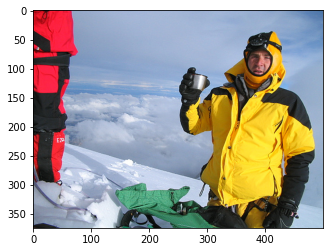

In [19]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import argparse
# from untitled0 import *

# ap = argparse.ArgumentParser()
# ap.add_argument('-i', '--image', required=True, help="Image Path")
# args = vars(ap.parse_args())
# img_path = args['image']
img_path="/content/drive/MyDrive/icg_project/sample1.jpg"


def extract_features(filename, model):
        try:
            image = Image.open(filename)

        except:
            print("ERROR: Couldn't open image! Make sure the image path and extension is correct")
        image = image.resize((299,299))
        image = np.array(image)
        # for images that has 4 channels, we convert them into 3 channels
        if image.shape[2] == 4: 
            image = image[..., :3]
        image = np.expand_dims(image, axis=0)
        image = image/127.5
        image = image - 1.0
        print(image.shape)
        feature = model.predict(image)
        return feature

def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None


def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo,sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'end':
            break
    return in_text


#path = 'Flicker8k_Dataset/111537222_07e56d5a30.jpg'
max_length = 32
tokenizer = load(open("/content/tokenizer.p","rb"))
model = load_model('/content/drive/MyDrive/icg_project/models/model_9.h5')
xception_model = Xception(include_top=False, pooling="avg")

photo = extract_features(img_path, xception_model)
img = Image.open(img_path)

description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)